In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-ct/demos/demo2.png
/kaggle/input/brain-ct/demos/demo3.png
/kaggle/input/brain-ct/demos/demo.jpg
/kaggle/input/brain-ct/demos/demo4.png
/kaggle/input/brain-ct/brain_CT_sinograms/56 (32).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/101 (24).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/116 (16).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/56 (2).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/106 (10).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/64 (1).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/96 (1) - Copy - Copy.jpg
/kaggle/input/brain-ct/brain_CT_sinograms/61 (22).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/98 (29) - Copy - Copy.jpg
/kaggle/input/brain-ct/brain_CT_sinograms/55 (32).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/50 (7).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/64 (17).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/126 (28).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/120 (23).jpg
/kaggle/input/brain-ct/brain_CT_sinograms/108 (25).jpg
/kagg

In [15]:
import tensorflow as tf
import os
import numpy as np
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [16]:
# Paths
input_dir = '/kaggle/input/brainctsinograms'
output_dir = '/kaggle/input/brain-ct/brain_CT'

# Get sorted file names (to ensure matching)
input_files = sorted(os.listdir(input_dir))
output_files = sorted(os.listdir(output_dir))


In [17]:
# Initialize lists
x_data = []
y_data = []

# Load images
for in_file, out_file in zip(input_files, output_files):
    # Load grayscale image and resize to (256, 256)
    input_img = load_img(os.path.join(input_dir, in_file), color_mode='grayscale', target_size=(363,256))
    output_img = load_img(os.path.join(output_dir, out_file), color_mode='grayscale', target_size=(256, 256))
    
    # Convert to array and normalize to [0, 1]
    x = img_to_array(input_img) / 255.0
    y = img_to_array(output_img) / 255.0

    x_data.append(x)
    y_data.append(y)

# Convert to NumPy arrays
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)

print("Input shape:", x_data.shape)   # (125, 256, 256, 1)
print("Output shape:", y_data.shape)  # (125, 256, 256, 1)

Input shape: (125, 363, 256, 1)
Output shape: (125, 256, 256, 1)


In [18]:
x_train = x_data[:100]
x_test = x_data[100:]
y_train = y_data[:100]
y_test = y_data[100:]

In [19]:
print(x_train.shape)
print(y_train.shape)

(100, 363, 256, 1)
(100, 256, 256, 1)


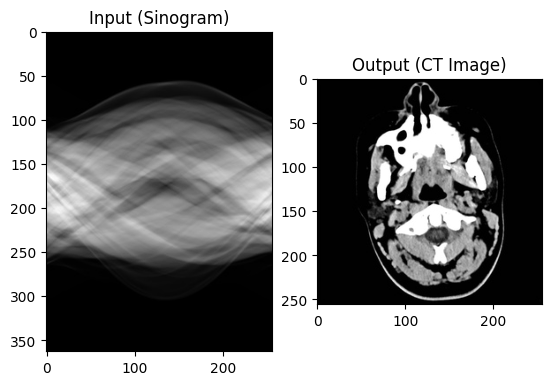

In [20]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(x_data[0].squeeze(), cmap='gray')
plt.title('Input (Sinogram)')

plt.subplot(1, 2, 2)
plt.imshow(y_data[0].squeeze(), cmap='gray')
plt.title('Output (CT Image)')
plt.show()

# Model

In [22]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Input, UpSampling2D

def build_automap(input_shape=(363, 256, 1), downscale_by = 4, m1=32, m2=64):
    inputs = Input(shape=input_shape)
    downscale_x_to = int(input_shape[0]/downscale_by)
    downscale_y_to = int(input_shape[1]/downscale_by)
    # Downsample
    x = layers.Resizing(downscale_x_to,downscale_y_to)(inputs)

    # Fully Connected Layers
    x = Flatten()(x)
    x = Dense(2 * downscale_x_to * downscale_y_to, activation='tanh')(x)
    x = Dense(64 * 64, activation='tanh')(x)
    x = Dense(64 * 64, activation='tanh')(x)
    x = Reshape((64, 64, 1))(x)

    # Convolutional Layers
    x = Conv2D(m1, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(m2, (3, 3), padding='same', activation='relu')(x)

    # Upsample
    x = UpSampling2D(size=(4, 4))(x)

    # Final Deconv
    x = Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')(x)

    return models.Model(inputs, x)


In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
model = build_automap()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [24]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 363, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_6 (Resizing)                │ (None, 90, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 5760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 11520)               │      66,366,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4096)                │      47,190,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 256, 256, 1)         │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 130,357,441 (497.27 MB)

 Trainable params: 130,357,441 (497.27 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Training
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=4,
    epochs=300,
    verbose=1
)

Epoch 1/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0272 - mean_absolute_error: 0.0845 - val_loss: 0.0392 - val_mean_absolute_error: 0.1011
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0281 - mean_absolute_error: 0.0860 - val_loss: 0.0386 - val_mean_absolute_error: 0.1002
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0261 - mean_absolute_error: 0.0822 - val_loss: 0.0390 - val_mean_absolute_error: 0.1017
Epoch 4/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0246 - mean_absolute_error: 0.0800 - val_loss: 0.0391 - val_mean_absolute_error: 0.1010
Epoch 5/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0260 - mean_absolute_error: 0.0822 - val_loss: 0.0383 - val_mean_absolute_error: 0.0991
Epoch 6/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0242 - mean_absolute_error: 0.0789 - val_loss: 0.0388 - val_mean_absolute_error: 0.0999
Epoch 7/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0249 - mean_absolute_error: 0.0787 - v

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


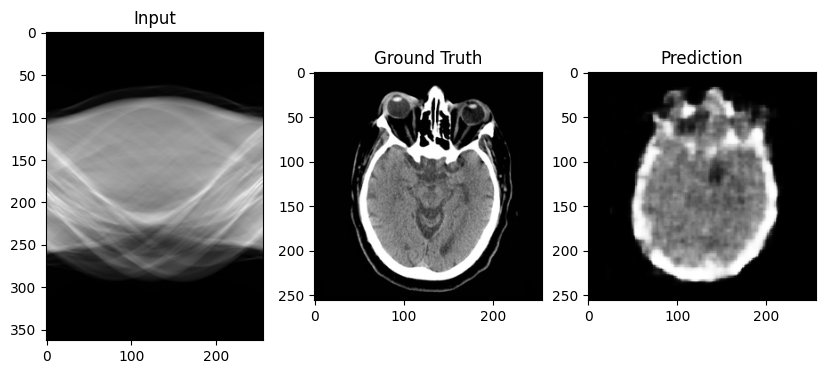

In [32]:
import matplotlib.pyplot as plt

i = 5  # index of sample
pred = model.predict(x_test[i:i+1])[0]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.imshow(x_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(y_test[i].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.imshow(pred.squeeze(), cmap='gray')
plt.show()


## Evaluate

In [33]:
import tensorflow as tf

# Get prediction
pred = model.predict(x_test[i:i+1])  # shape: (1, 256, 256, 1)

# Extract image arrays
gt = y_test[i:i+1]

# PSNR
psnr_val = tf.image.psnr(gt, pred, max_val=1.0).numpy()[0]

# SSIM
ssim_val = tf.image.ssim(gt, pred, max_val=1.0).numpy()[0]

print(f"PSNR: {psnr_val:.2f} dB")
print(f"SSIM: {ssim_val:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
PSNR: 14.06 dB
SSIM: 0.4862
